# Physical Modelling 3
- Longitudinal Wave
- Can reduce spatial resolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython.display import Audio
from scipy.io.wavfile import write
from datetime import datetime
import subprocess

In [2]:
def get_interpolated(array, index):
    if not hasattr(index, "__len__") or len(index) < 1: return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [3]:
def interpolate_1d(array, indices):
    t = indices.reshape(-1, 1, 1) % 1
    left = array[np.floor(indices).astype(np.int64)]
    right = array[np.ceil(indices).astype(np.int64)]
    print("first step done")
    return (1 - t) * left + t * right

In [4]:
interpolate_1d(np.array([[1, 2],[3, 4]]), np.array([0.5]))

first step done


array([[[2., 3.]]])

# Simulation

In [5]:
import simulation

n = 128
sim_speed = 0.004
sim_fps = 400
duration = 5
frame_amount = duration * sim_fps

double_slit = [(-4, -2), (2, 4)]
single_slit = [(-2, 2)]
slits = double_slit

frames = simulation.sim(n, sim_fps, duration, slits, sim_speed)

# Video

In [6]:
# create visual barrier for plot
def visual_barrier(barrier_gaps):
    start = 0
    rects = []
    for g in barrier_gaps:
        end = n//2 + g[0]
        rect = patches.Rectangle((n//2 - 1.5, start - 0.5), 1, end - start, linewidth=0, facecolor='#60b0ff')
        start = n//2 + g[1]
        rects.append(rect)
    rects.append(patches.Rectangle((n//2 - 1.5, start - 0.5), 1, n - start, linewidth=0, facecolor='#60b0ff'))
    return rects

video saved as output/simulation_2024_04_15-15_24_01.mp4


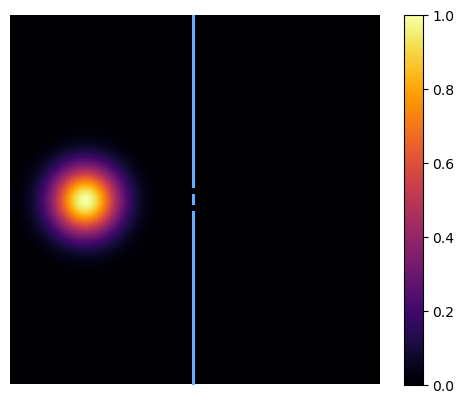

In [7]:
# FuncAnimation
video_fps = 20

fig, ax = plt.subplots()
plt.axis('off')  # big performance boost

data = pow(np.abs(frames[0]), 2.0/3.0)
cax = ax.imshow(data, cmap='inferno', vmin=0, vmax=1)
for b in visual_barrier(slits):
    ax.add_patch(b)
fig.colorbar(cax)  # no performance impact (?)

def animate(i):
    cax.set_array(pow(np.abs(frames[i * sim_fps // video_fps]), 2.0/3.0))

anim = animation.FuncAnimation(fig, animate, frames=frame_amount * video_fps // sim_fps)
video_filename = f'output/simulation_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

anim.save(video_filename, fps=video_fps, dpi=150, bitrate=4000)

print(f'video saved as {video_filename}')

# Sonification

In [8]:
a = np.array([1+1j, 1+1j])
b = a[:, None].view(float)
np.dot(b[0], b[1])

2.0

In [9]:
average_parallel_listening = lambda array: np.average(array[:, :, 0])
average_orthogonal_listening = lambda array: np.average(array[:, :, 1])
average_norm_listening = lambda array: np.average(np.linalg.norm(array, axis=2))

point_parallel_listening = lambda array: array[20, 60, 0]
point_orthogonal_listening = lambda array: array[20, 60, 1]

In [10]:
sample_rate = 44100
sonification_duration = 5
sonification_duration = np.min([duration, sonification_duration])

listening = average_orthogonal_listening

dampening_per_second = 1 - 1e-15
spring_amount = sample_rate * 15
min_mass = 0.00125
max_mass = 3.2

spatial_step = 4
m = n // spatial_step

dampening_per_sample = 1 - pow(1 - dampening_per_second, 1 / sample_rate)

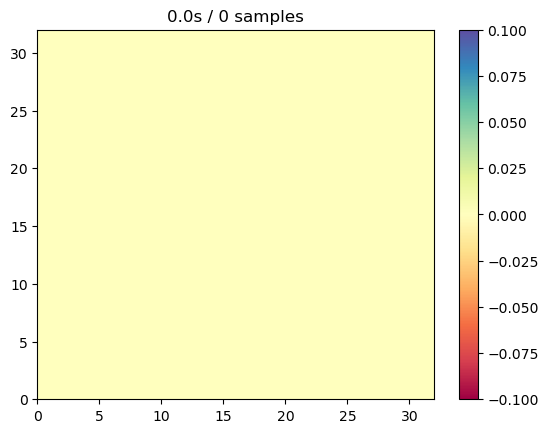

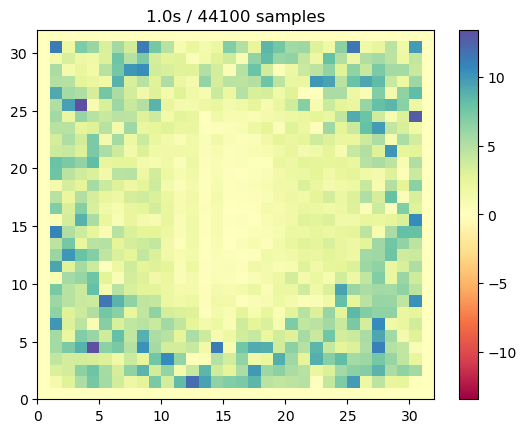

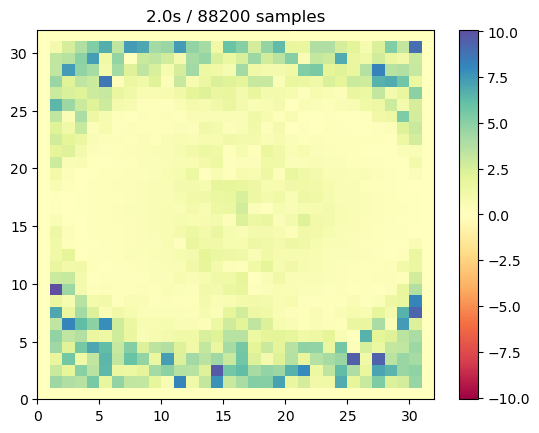

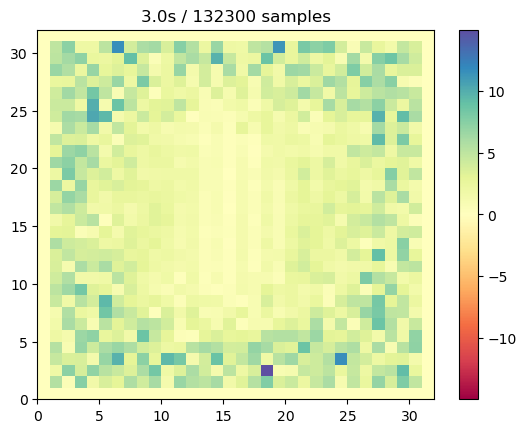

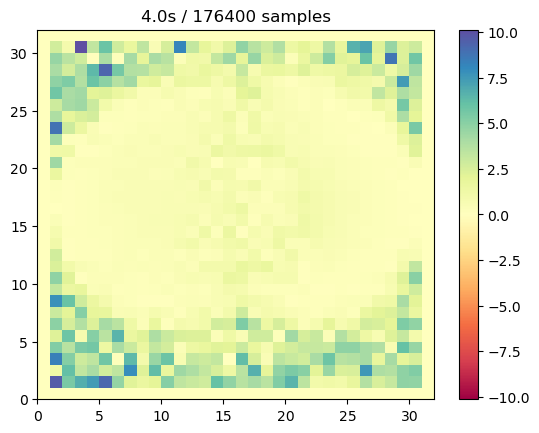

In [11]:
num_simulated_steps = sonification_duration * sample_rate
original_positions = np.indices((m, m), dtype=np.float64).transpose((1, 2, 0))
positions = np.copy(original_positions)
speeds = np.zeros((m-2, m-2, 2), dtype=np.float64)
forces = np.zeros((m-2, m-2, 2), dtype=np.float64)

audio = np.empty(num_simulated_steps)

data = frames[0, ::spatial_step, ::spatial_step]

for sample in range(num_simulated_steps):
    
    simulation_index = int(sample / sample_rate * sim_fps)
    last_data = data
    data = frames[simulation_index, ::spatial_step, ::spatial_step] # no interpolation
    
    masses = (min_mass + (max_mass - min_mass) * np.abs(data))[1:-1, 1:-1, np.newaxis]
    angles = np.angle(data)
    
    bottom_offset = positions[ :-2, 1:-1] - positions[1:-1, 1:-1]
    top_offset    = positions[2:  , 1:-1] - positions[1:-1, 1:-1]
    left_offset   = positions[1:-1,  :-2] - positions[1:-1, 1:-1]
    right_offset  = positions[1:-1, 2:  ] - positions[1:-1, 1:-1]
    
    bottom_spring_length = (1 - np.cos(angles[ :-2, 1:-1] - angles[1:-1, 1:-1]))
    top_spring_length    = (1 - np.cos(angles[2:  , 1:-1] - angles[1:-1, 1:-1]))
    left_spring_length   = (1 - np.cos(angles[1:-1,  :-2] - angles[1:-1, 1:-1]))
    right_spring_length  = (1 - np.cos(angles[1:-1, 2:  ] - angles[1:-1, 1:-1]))

    forces = np.zeros((m-2, m-2, 2), dtype=np.float64)
    forces += spring_amount * bottom_offset * (1 - bottom_spring_length / np.linalg.norm(bottom_offset, axis=2))[:, :, np.newaxis]
    forces += spring_amount * top_offset    * (1 - top_spring_length    / np.linalg.norm(top_offset   , axis=2))[:, :, np.newaxis]
    forces += spring_amount * left_offset   * (1 - left_spring_length   / np.linalg.norm(left_offset  , axis=2))[:, :, np.newaxis]
    forces += spring_amount * right_offset  * (1 - right_spring_length  / np.linalg.norm(right_offset , axis=2))[:, :, np.newaxis]
    
    # Add noise
    forces[:, :, 0] += np.abs(np.abs(last_data) - np.abs(data))[1:-1, 1:-1] * (2 * np.random.random((m-2, m-2)) - 1)

    # Update speeds with forces, apply dampening
    speeds += forces / masses / sample_rate
    speeds *= 1 - dampening_per_sample #/ masses[:, :, np.newaxis]
    
    positions[1:-1, 1:-1] += speeds / sample_rate

    audio[sample] = listening(positions - original_positions)

    #'''
    #if sample % (sample_rate // 100) == 0: print(f"{round(sample/sample_rate, 3)}s")
    if sample % (sample_rate * sonification_duration // 5) == 0:
        plot_data = np.abs(np.linalg.norm(positions - original_positions, axis=2))
        scale = np.max(plot_data)
        plt.pcolormesh(plot_data, vmin=-scale, vmax=scale, cmap='Spectral')
        plt.colorbar()
        plt.title(f"{round(sample/sample_rate, 2)}s / {sample} samples")
        plt.show()
    #'''

In [12]:
audio[:1000]  *= np.square(np.linspace(start=0, stop=1, num=1000, endpoint=False))
audio[-1000:] *= np.square(np.linspace(start=1, stop=0, num=1000, endpoint=False))
audio_filename = f'output/sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16))
print(f"Sonification saved as {audio_filename}")
Audio(audio, rate=sample_rate)

Sonification saved as output/sonification_2024_04_15-15_25_26.wav


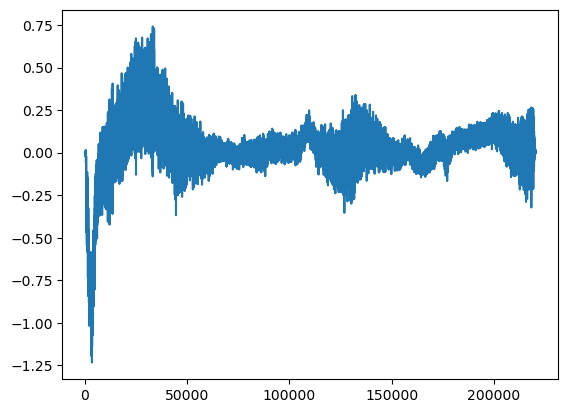

In [14]:
plt.plot(audio)

# Combine Audio & Video

In [16]:
combined_filename = f'output/combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    'ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

CompletedProcess(args=['ffmpeg', '-i', 'output/simulation_2024_04_15-15_24_01.mp4', '-i', 'output/sonification_2024_04_15-15_25_26.wav', '-c:v', 'copy', '-c:a', 'aac', '-shortest', 'output/combination_2024_04_15-15_25_27.mp4'], returncode=0)